# Sticky Trap Image Analysis

Use the Pyton 3 kernel.

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [40]:
def rescale(size, img):
    '''
    Places img at the center of a square mask with width and height equal to size.
    Images larger than the mask are shrunk.
    '''
    # create mask with specified size and type
    mask = np.zeros((size, size, 3), dtype=img.dtype)
    center = size//2

    # shrink image if it is larger than the mask
    h, w = img.shape[:2]
    scale = size/max(h,w)
    if scale < 1:
        new_w = int(w*scale)
        new_h = int(h*scale)
        img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
        h, w = img.shape[:2]

    # insert img at the center of the mask
    ypos = center - h//2
    xpos = center - w//2
    mask[ypos:ypos+h, xpos:xpos+w, :] = img
    
    return mask

# imgpath = 'my_sticky_trap/022b.png'
# img = cv2.imread(imgpath)
# mask = rescale(100, img)
# plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

In [41]:
def rotate_and_crop(imagepath, outputpath, rects, rescale_size):
    '''
    imagepath: path to image file
    
    rects: a list of rectangular areas returned by bugcount; cv2.minAreaRect formats each rectangle as:
          (center(x, y), (width, height), angle of rotation)
        
    outputpath: specifies a directory in which rotated and cropped images are saved; each is named NNN.png
    
    Rescaled images of fixed size are stored in {outputpath}/rescaled/NNN.png
    
    Code inspired by https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/
    '''
    
    img = cv2.imread(IMAGEPATH)
    
    i = 0
    for rect in rects:
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # get width and height of the detected rectangle
        width = int(rect[1][0])
        height = int(rect[1][1])
        pixels = width * height
        if pixels < MINPIXELS:
            continue
        i += 1
        src_pts = box.astype("float32")

        # coordinate of the points in box points after the rectangle has been straightened
        dst_pts = np.array([[0, height-1],
                            [0, 0],
                            [width-1, 0],
                            [width-1, height-1]], dtype="float32")

        # the perspective transformation matrix
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # directly warp the rotated rectangle to get the straightened rectangle
        warped = cv2.warpPerspective(img, M, (width, height))
        
        # Rotate so that the long axis is vertical
        height, width, _ = warped.shape
        if height < width:
            warped = cv2.rotate(warped, cv2.cv2.ROTATE_90_CLOCKWISE) 
        
        cv2.imwrite(f'{outputpath}/{i:03d}a.png', warped)
        rescaled = rescale(rescale_size, warped)
        cv2.imwrite(f'{outputpath}/{i:03d}a_rescaled.png', rescaled)
        
        warped = cv2.rotate(warped, cv2.cv2.ROTATE_180) 
        cv2.imwrite(f'{outputpath}/{i:03d}b.png', warped)
        rescaled = rescale(rescale_size, warped)
        cv2.imwrite(f'{outputpath}/{i:03d}b_rescaled.png', rescaled)
                      
# rotate_and_crop(IMAGEPATH, OUTPUTPATH, rects, RESCALESIZE)

In [42]:
def bugcount(imagepath, canny=75, minpixels=100):
    '''
    This code is based on bugcount.py from https://github.com/ytakefuji/counting-for-entomologists.
    '''
    img = cv2.imread(imagepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    blurred = cv2.GaussianBlur(blurred, (7,7), 0)
    coeff=int((blurred.max()-blurred.min())/100)
    if coeff==1: 
        coeff=1 
    else: 
        coeff=3
    outline = cv2.Canny(blurred, 0, int(canny)*coeff)
    outline= cv2.GaussianBlur(outline, (3,3), 0)
    contours, _ = cv2.findContours(outline,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)   
    
    # Calculate bounding boxes
    
    boxes = []
    rects = []
    i = 0
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        pixels = rect[1][0] * rect[1][1]
        if pixels < minpixels:
            continue
        i += 1            
        rects.append(rect)
        box = np.int0(cv2.boxPoints(rect)) 
        boxes.append(box)
    
    # Draw contours on img
    
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    cv2.drawContours(img, boxes, -1, (0, 0, 255), 2)
    
    cv2.putText(img,f'{imagepath} canny:{canny} minpixels:{minpixels} box count:{len(boxes)}',
                (30,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)

    # Number each box
    
    i = 0
    for rect in rects:
        i += 1
        cv2.putText(img, str(i), (int(rect[0][0]), int(rect[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)       

    return contours, rects, boxes, img

# # Process a sticky trap image
# contours, rects, boxes, img = bugcount(IMAGEPATH, 45, 200)

# # Display results
# fig, ax = plt.subplots(1, 1, figsize=(20,20))
# fig.tight_layout()
# ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# ax.set_title('bugcount result')
# ax.axis('off')

In [43]:
IMAGEPATH = '/home/aubrey/Desktop/my_sticky_trap.jpg'
MINPIXELS = 1000
OUTPUTPATH = 'my_sticky_trap'
CANNY = 45
RESCALESIZE = 224

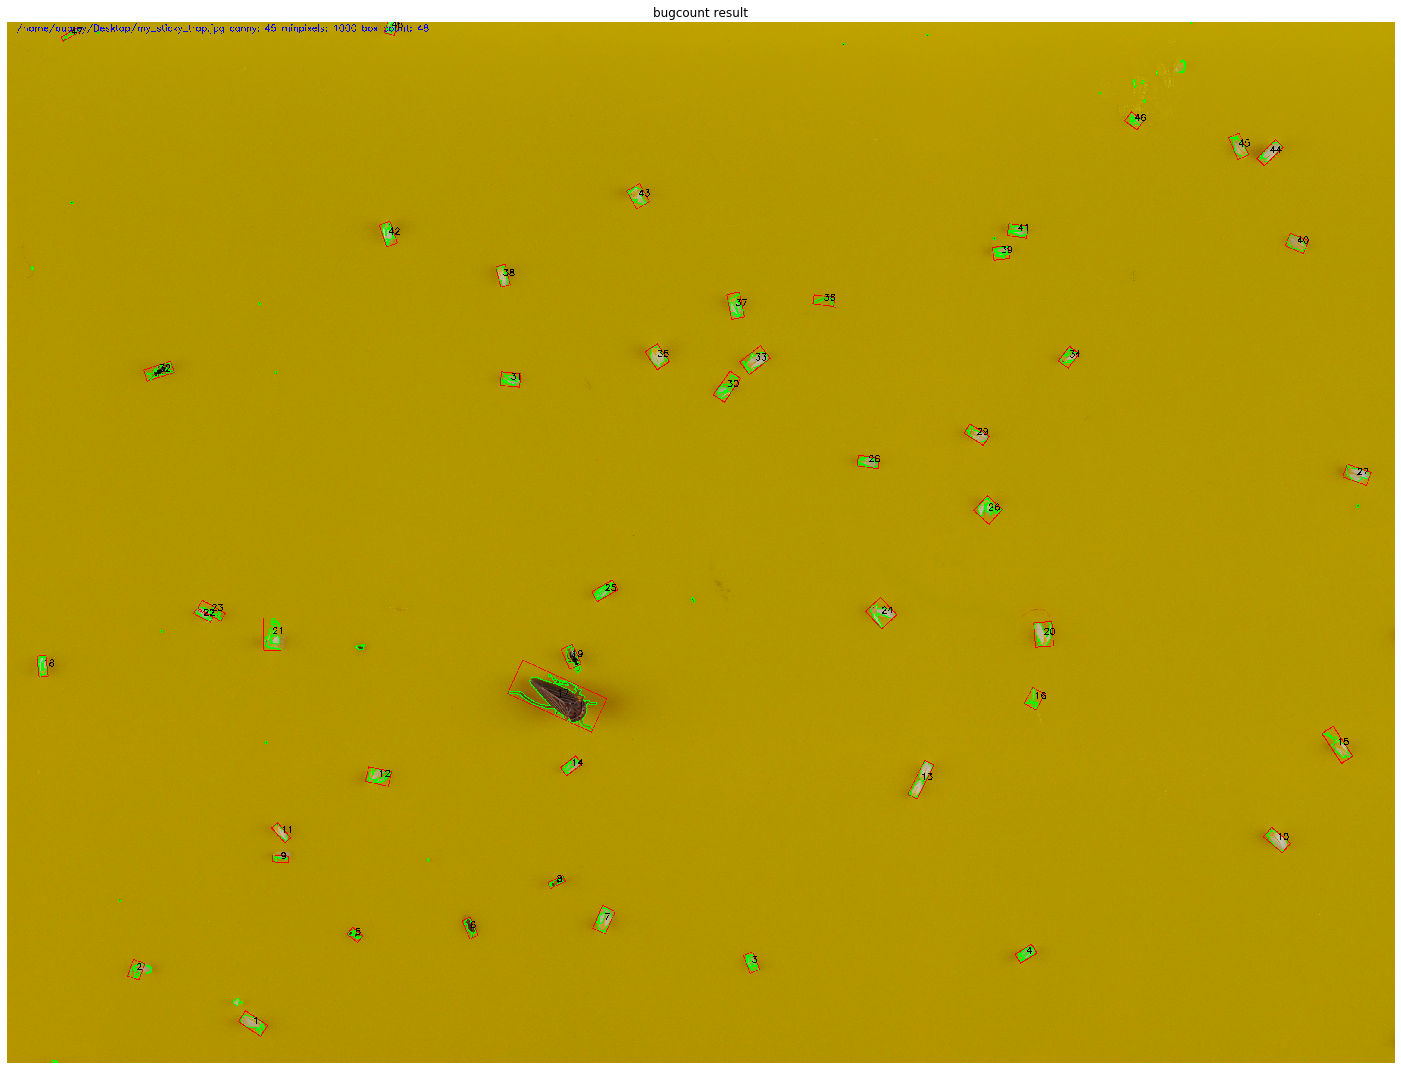

In [44]:
# MAIN

# Use the bugcount algorithm to draw contours around insects and other objects

contours, rects, boxes, img = bugcount(IMAGEPATH, CANNY,MINPIXELS)

# Display bugcount result image

fig, ax = plt.subplots(1, 1, figsize=(20,20))
fig.tight_layout()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('bugcount result')
ax.axis('off')

# Save bugcount result image and original image in OUTPUTPATH

if os.path.exists:
    shutil.rmtree(OUTPUTPATH)
os.makedirs(OUTPUTPATH)
cv2.imwrite(f'{OUTPUTPATH}/bugcount.png', img)
shutil.copy2(IMAGEPATH, OUTPUTPATH) 

# Extract pixels within each rotated rectangle and rotate so that one axis is horizontal and the other is vertical
# Then rescale images to a fixed size
# All resulting images will be saved in OUTPUTPATH directory

rotate_and_crop(IMAGEPATH, OUTPUTPATH, rects, RESCALESIZE)